# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
])
# Create training set and define training dataloader
## YOUR CODE HERE ##
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose to apply two preprocessing steps to the MNIST dataset: converting the images to tensors and normalizing them. The ToTensor() transform is essential because the original MNIST images are in PIL format, and PyTorch models require input data to be in the form of tensors. This step also scales the pixel values from a range of 0–255 to a range of 0.0–1.0, which is more suitable for training neural networks. The normalization step uses the mean and standard deviation of the MNIST dataset—specifically, a mean of 0.1307 and a standard deviation of 0.3081—to standardize the input data. This helps the model learn more efficiently by ensuring that the input features have a consistent scale. Overall, these preprocessing steps are common best practices that improve model performance and training stability.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [10]:
# Explore data
## YOUR CODE HERE ##

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 -> 784
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28x28 -> 784
])

train_set1 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_set1 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader1 = torch.utils.data.DataLoader(train_set1, batch_size=64, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(test_set1, batch_size=64, shuffle=False)
# Define a separate transform for viewing: only ToTensor (no normalization or flattening)
view_transform = transforms.ToTensor()
view_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=view_transform)
view_loader = torch.utils.data.DataLoader(view_set, batch_size=64, shuffle=True)




Batch shape (images): torch.Size([64, 1, 28, 28])
Single image shape: torch.Size([1, 28, 28])
Labels shape: torch.Size([64])
8


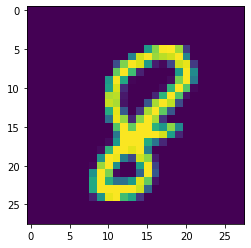

0


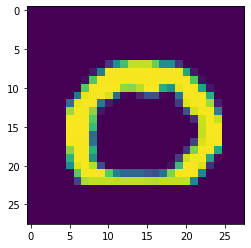

2


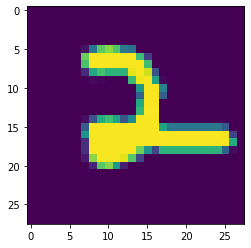

3


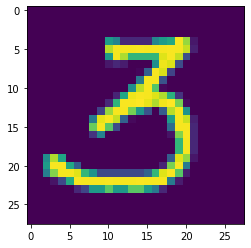

4


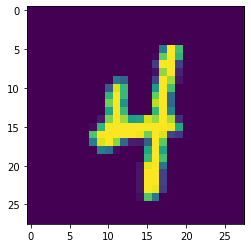

In [11]:
# Explore data dimensions
images, labels = next(iter(view_loader))
print("Batch shape (images):", images.shape)    # [64, 1, 28, 28]
print("Single image shape:", images[0].shape)   # [1, 28, 28]
print("Labels shape:", labels.shape)            # [64]

# Visualize 5 sample images
show5(view_loader)

I used normalization with mean 0.1307 and standard deviation 0.3081, which are the dataset's global statistics. This helps the network converge faster and perform better. I also flattened the 28x28 images into 784-dimensional vectors because my model is a fully connected neural network (not a convolutional one), and linear layers expect 1D input. For visualization, I used a separate transform with only ToTensor() so that the images appear correctly (un-normalized and un-flattened).

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [16]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # input size 784, not 256
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [17]:
## YOUR CODE HERE ##
model = MNISTNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()  # Negative Log Likelihood Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [18]:
## YOUR CODE HERE ##
epochs = 10
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader1):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader1)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 0.2703
Epoch 2/10, Loss: 0.1108
Epoch 3/10, Loss: 0.0756
Epoch 4/10, Loss: 0.0594
Epoch 5/10, Loss: 0.0468
Epoch 6/10, Loss: 0.0390
Epoch 7/10, Loss: 0.0333
Epoch 8/10, Loss: 0.0278
Epoch 9/10, Loss: 0.0262
Epoch 10/10, Loss: 0.0223


Plot the training loss (and validation loss/accuracy, if recorded).

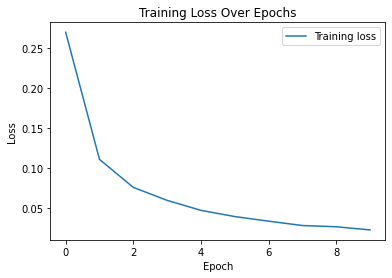

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [20]:
## YOUR CODE HERE ##
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.58%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [22]:
## YOUR CODE HERE ##

class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)

        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

model = ImprovedNet().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader1:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader1:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1/10, Loss: 0.2615
Epoch 2/10, Loss: 0.1320
Epoch 3/10, Loss: 0.1069
Epoch 4/10, Loss: 0.0916
Epoch 5/10, Loss: 0.0799
Epoch 6/10, Loss: 0.0703
Epoch 7/10, Loss: 0.0636
Epoch 8/10, Loss: 0.0588
Epoch 9/10, Loss: 0.0523
Epoch 10/10, Loss: 0.0495
Test Accuracy: 98.28%


## Saving your model
Using `torch.save`, save your model for future loading.

In [23]:
## YOUR CODE HERE ##
# Save the entire model
torch.save(model.state_dict(), "mnist_model.pth")
